<a href="https://colab.research.google.com/github/thetocha/DLS/blob/main/homework_pytorch_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Библиотека Pytorch

В этом занятии вам предстоит потренироваться в обучении моделей с помощью библиотеки Pytorch. Мы будем работать с игрушечным датасетом moons. Вам предстоит самостоятельно реализовать в Pytorch логистическую регрессию и обучить ее. 

## Оценивание задания
Это задание будет проверяться в формате peer-review. Это означает, что вашу посылку на Stepik будут проверять 3 других учащихся, и медианное значение их оценок будет выставлено в качестве окончательного балла. Чтобы получить баллы, вам также нужно будет проверить трех других учеников. Это станет доступно после того, как вы сдадите задание сами.

## Оформление посылки
В качестве решения необходимо послать ноутбук в формате .ipynb. Пожалуйста, сделайте файл максимально читаемым. Если размер вашего файла превышает 5 Мб, приложите текстовый документ со ссылкой на файл в Google Drive (не забудьте обеспечить доступ на чтение). Пожалуйста, проследите, чтобы у файла было верное расширение: иначе у других участников могут возникнуть проблемы с прочтением.

## Рекомендации по решению
Подробные критерии проверки станут доступными во время проверки на Stepik. Пока мы предлагаем несколько правил, которые помогут вам набрать максимальное количество баллов. 
* Сначала оформите ноутбук, а затем перезапустите среду выполнения и выполните ноутбук заново (Среда выполнения→перезапустить и выполнить всё). Так вы убедитесь, что итоговый код вашего ноутбука корректен. 
* В ноутбуке есть два типа проверки: `assert`'ы и 3 ключевых вопроса. Корректное решение должно проходить все `assert`-ы. Также необходимо дать ответы на все вопросы из ноутбука.
* Чем более понятным и читаемым вы сделаете код, тем больше шансов, что проверяющий поставит вам за него высокий балл. 

Желаем удачи!







In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

## Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

y = 2 * y - 1 # Делаем из классов (0, 1) классы +- 1

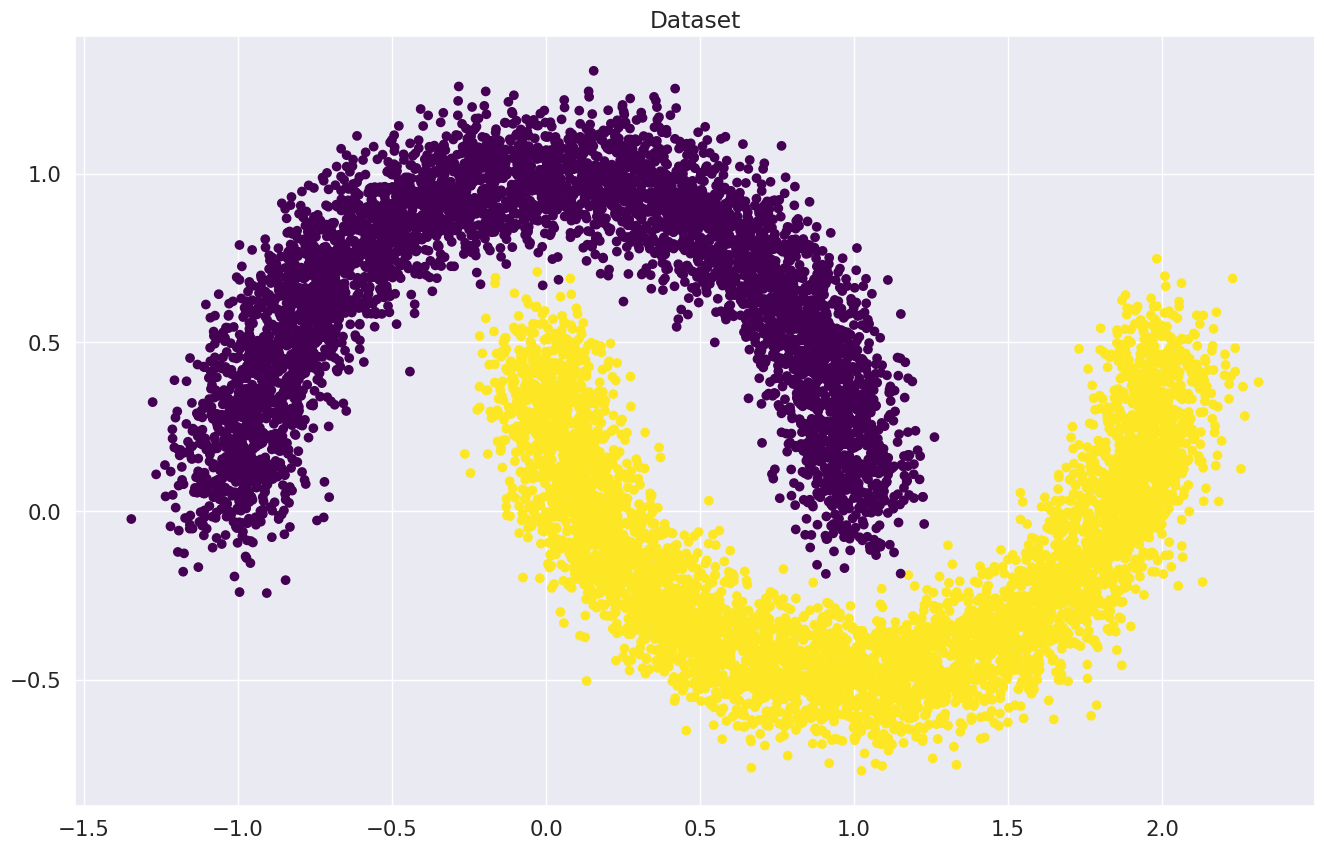

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
from torch.utils.data.distributed import Dataset
X_train_t =  torch.tensor(X_train)
y_train_t =  torch.tensor(y_train)
X_val_t =  torch.tensor(X_val)
y_val_t =  torch.tensor(y_val)

In [55]:
X_val_t.shape

torch.Size([2500, 2])

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, как устроена логистическая регрессия. На входе у нас есть матрица объекты-признаки $X$ размера $\ell \times n$ и вектор-столбец $y$ размера $\ell$ --- метки классов из $\{-1, +1\}$ для каждого объекта. 


### Вычисление логитов
Пусть $x$ --- одна строчка матрицы $X$ (вектор признаков одного объекта). Мы хотим найти такой вектор весов (weights) $w$ размера $n$, чтобы число $\sigma(\langle x, w \rangle)$ интерпретировалось как вероятность того, что объект $x$ принадлежит классу $+1$ против класса $-1$. Тогда вероятность принадлежности классу $-1$ будет вычисляться как $1 - \sigma(\langle x, w \rangle)$.

Здесь $$\sigma(z) = \frac{1}{1+e^{-z}}.$$

### Функция потерь и обучение
Задача обучения модели логистической регрессии состоит в том, чтобы подобрать такую матрицу весов $w$, чтобы максимизировать логистическую функцию потерь, которую ещё называют logloss.

Формула для вычисления логистической функции потерь представлена ниже:
$$Logloss = \frac{1}{\ell}\sum\limits_{i=1}^{\ell}\ln(1 + e^{-y^i \langle x^i, w\rangle}) \rightarrow \min_{w}.$$ 

Здесь $x^i$ --- это вектор признаков $i$-ого объекта, а $y^i$ --- класс $i$-ого объекта ($\pm 1$). Эту формулу мы выводили на занятии по логистической регрессии. 


### Задание 1. Реализация логистической регрессии (2 балла)

Вам необходимо написать модуль на PyTorch, реализующий функцию $f(X) = Xw$, где $w$ --- параметр (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено) без свободного члена. Инициализируйте веса нормальным распределением (`torch.randn`).

В самом модуле LogisticRegression мы не применяем к выходу сигмоиду, поскольку после этого неудобно будет вычислять функцию потерь. Сигмоиду нужно будет применять к выходу самостоятельно. Поэтому модуль LogisticRegression не будет отличаться от модуля LinearRegression, который мы реализовывали на семинаре [Введение в Pytorch](https://drive.google.com/file/d/1j16uJKDYulUOtRpGxGE4X5kvJIjUCppm/view?usp=sharing).

In [7]:
class LogisticRegression(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(n, 1).type(torch.float64), requires_grad=True)    

    def forward(self, x): #x has shape (l, n)
        result =  x @ self.weights
        return result

In [8]:
test_model = LogisticRegression(n=2)

### Вычисление логистической функции потерь в Pytorch
Как вычислить логистическую функцию потерь с помощью операций Pytorch? Пусть $X$ --- матрица объекты-признаки размерности $\ell \times n$, $y$ --- вектор размерности $\ell$, $w$ --- вектор весов размерности $n$. 

* Если $X$ --- это матрица объекты-признаки, то вектор $Xw$ представляет из себя вектор из скалярных произведений 
$$(\langle x^1, w\rangle, \ldots, \langle x^{\ell}, w\rangle).$$ 
Здесь $Xw$ --- это матричное произведение матрицы $X$ на вектор $w$. Обратите внимание, что в Pytorch матричное произведение матрицы `X` на вектор `w` можно вычислить как `X @ w`. Не забудьте, что для матричного произведения необходимо, чтобы форма тензора w была `(n, 1)`.

Далее, $-(Xw) \odot y$ --- это вектор поэлементных произведений 
$$(-y^1\cdot \langle x^1, w\rangle, \ldots, -y^{\ell}\cdot \langle x^{\ell}, w\rangle).$$

Здесь $\odot$ --- это поэлементное произведение. В pytorch оно обозначается просто как умножение (*). Обратите внимание, что для корректного выполнения поэлементного произведения необходимо, чтобы форма вектора $Xw$ совпадала с формой вектора $y$, то есть форма вектора $y$ должна быть `(l, 1)`.

Наконец, последняя цепочка операций --- это поэлементные 
* применение к получившемуся вектору функции экспоненты (`torch.exp`), 
* прибавление единицы,
* логарифмирование (`torch.log`). 

### Задание 2. Вычисление функции потерь (3 балла)
Потренируемся в вычислении функции потерь, которая описана выше. Сейчас мы будем делать это на конкретных числах. 

Даны матрица объекты-признаки $X$, вектор весов $w$ и вектор правильных ответов $y$. 

In [9]:
X_batch = torch.DoubleTensor([[2., 0.5], [0.3, -4.5], [8.2, 0.4]])
w = torch.DoubleTensor([3.6, -2.2]).view(2, 1)
y_batch = torch.tensor([1, -1, 1])
X_batch, w, y_batch 

(tensor([[ 2.0000,  0.5000],
         [ 0.3000, -4.5000],
         [ 8.2000,  0.4000]], dtype=torch.float64),
 tensor([[ 3.6000],
         [-2.2000]], dtype=torch.float64),
 tensor([ 1, -1,  1]))

Вычислите функцию потерь по алгоритму выше.

In [15]:
test_model.weights = nn.Parameter(w, requires_grad=True)

#YOUR CODE. Вычислите матричное произведение X_batch и w. Используйте объект test_model
outp = test_model(X_batch)

outp = outp.flatten()

#YOUR CODE. Вычислите вектор размера 3 из компонент -y^i * <x^i, w>
outp1 = -y_batch * outp

exp = torch.exp(outp1)

#YOUR CODE. Вычислите вектор размера 3 из компонент ln(1 + e^(-y^i * <x^i, w>))
all_losses = torch.log(1 + exp)

loss = torch.mean(all_losses)

Проверьте, что вы правильно вычислили функцию потерь на этих объектах. В клетке ниже мы проверяем это с помощью функции `torch.allclose()`, которая проверяет, что тензор, который получился у вас, совпадает с тензором, который должен был получиться. Если у вас вылетела ошибка, вернитесь к заданию 2. В норме клетка должна отработать без ошибок. 

In [17]:
assert torch.allclose(loss, torch.DoubleTensor([3.66]), rtol=1e-3), 'Пока неверно. Провертье реализацию класса LogisticRegression и функцию потерь'

### Код обучения

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание 3. Реализация цикла обучения (3 балла)

In [18]:
logistic_regression = LogisticRegression(n=2)
optimizer = torch.optim.SGD(logistic_regression.parameters(), lr=0.05)

In [36]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(logistic_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()

        # YOUR CODE. Используйте объект logistic_regression, чтобы вычислить outputs на X_batch.
        outp =  logistic_regression(X_batch)
        

        outp = outp.flatten()

        # YOUR CODE. Вычислите функцию потерь. Используйте алгоритм вычисления, который вы реализовали в предыдущем задании.
        loss = torch.mean(torch.log(1 + torch.exp(-y_batch * outp))) 

        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()

        # YOUR CODE. Вычислите вероятности по формуле σ(Xw). Используйте переменную outp.
        probabilities =  torch.sigmoid(outp)
        
        preds = (probabilities > 0.5).type(torch.long) # сейчас preds равны 0 или 1
        preds = preds * 2 - 1 # а теперь уже +- 1 

        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = logistic_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.828125

Iteration: 16.Convergence. Stopping iterations.


**Вопрос 1.** Сколько итераций потребовалось, чтобы алгоритм сошелся? **Обратите внимание, после перезапуска ноутбука перед отправкой на Stepik это число может измениться, так как есть небольшая случайная вариативность. Введите ответ, который дает итоговая версия вашего ноутбука.**

**Ответ:**

### Визуализируем результаты

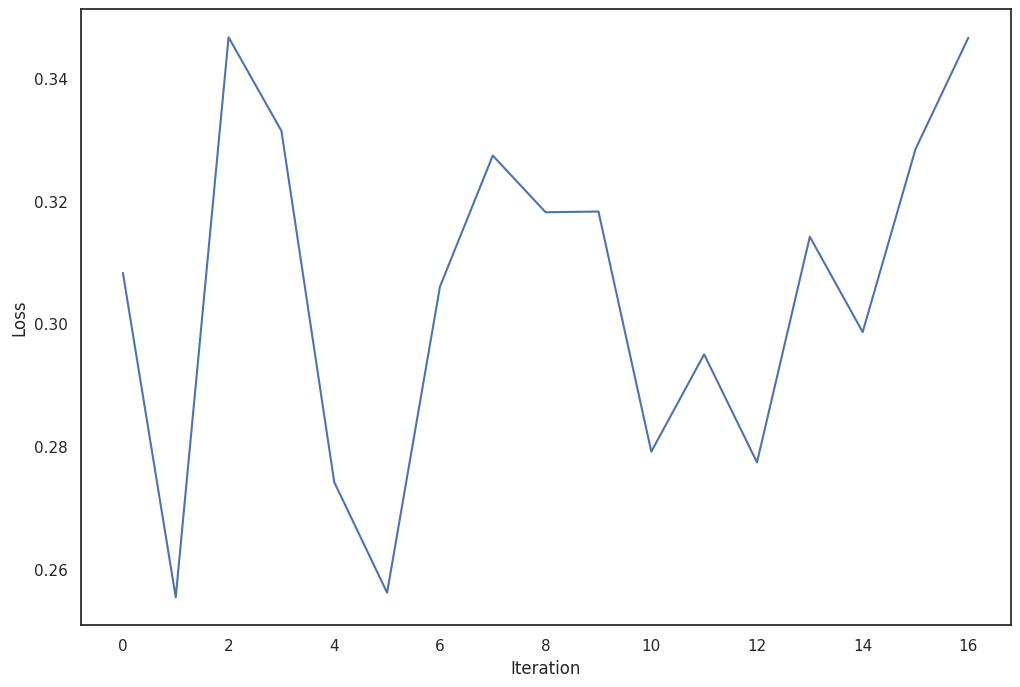

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

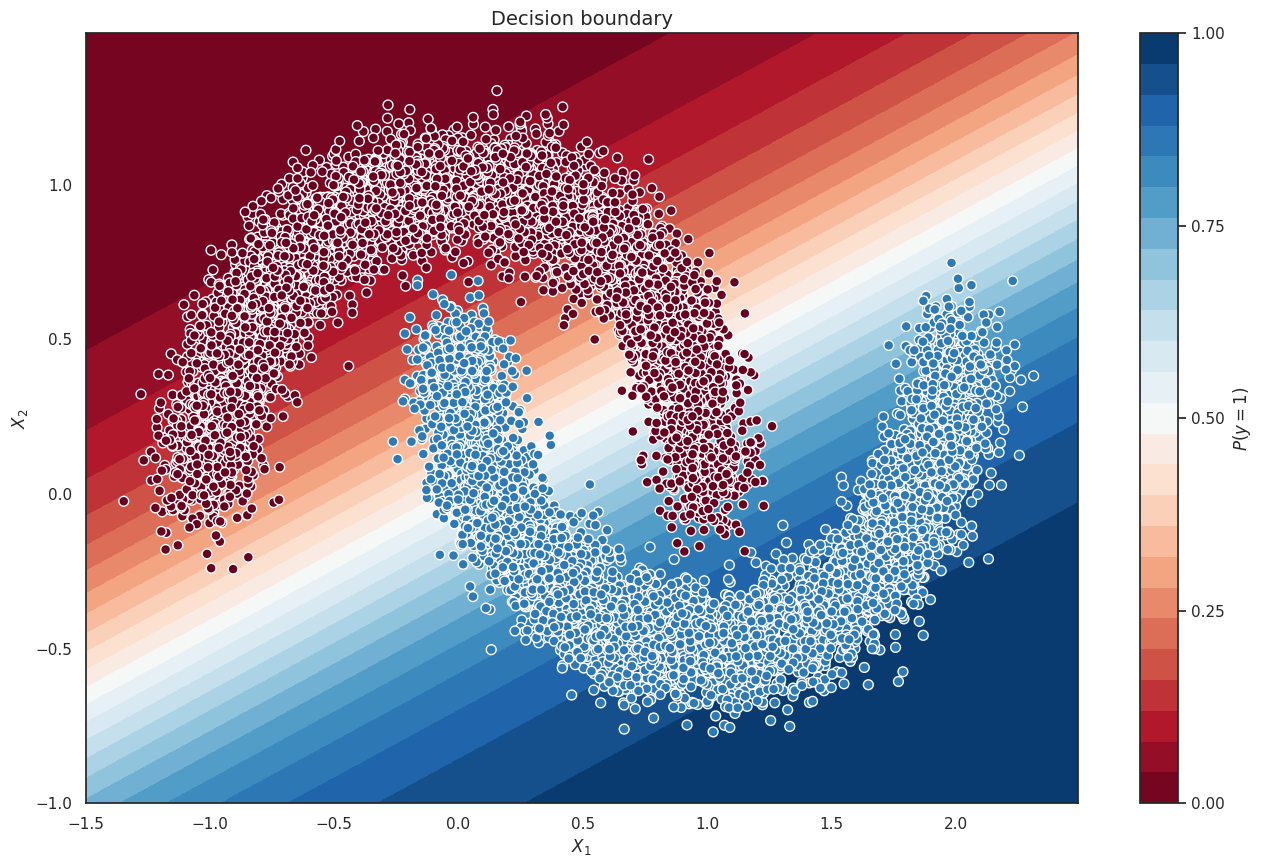

In [38]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float64)
with torch.no_grad():
    probs = torch.sigmoid(logistic_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

Сравним с картинкой, которую дает логистическая регрессия, реализованная в библиотеке sklearn.

In [29]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import accuracy_score

model = lr(C=10000).fit(X_train, y_train)
accuracy_score(y_val, model.predict(X_val))


0.8916

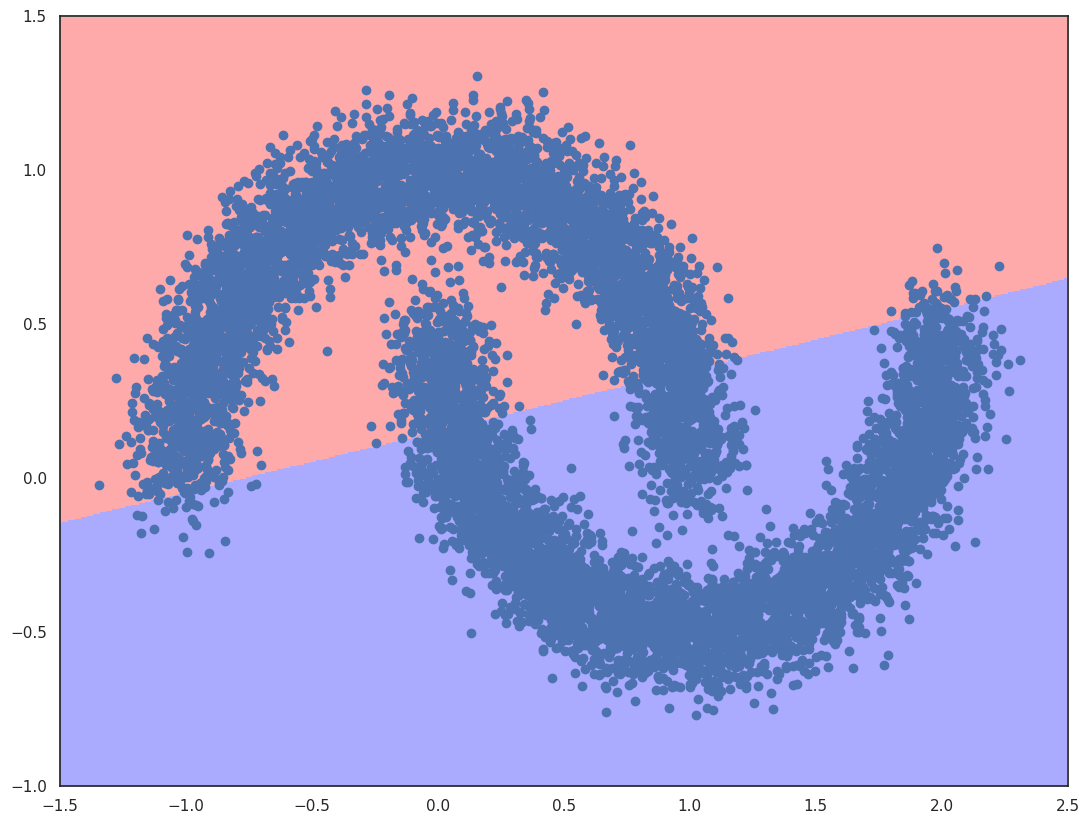

In [30]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

plt.figure(figsize=(13,10))

x_min = -1.5
x_max = 2.5
y_min = -1.
y_max = 1.5
h = 0.005

plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1],)
plt.show()

**Вопрос 2**. Совпадают ли разделяющие поверхности?

**Ответ:**

### Задание 4. Реализуйте predict и посчитайте accuracy на всем тестовом множестве (2 балла)

Функция predict должна возвращать вектор из $\ell$ 
элементов, каждый из которых равен $\pm 1$.

In [59]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()

    outp = model(X_val_t).flatten()
    
    outp = torch.sigmoid(outp)

    preds = (outp > 0.5).type(torch.long)
    preds = 2 * preds - 1

    return preds

In [61]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val_t, predict(val_dataloader, logistic_regression))

0.8696

**Вопрос 3**

Какое `accuracy` получается после обучения? **Обратите внимание, после перезапуска ноутбука перед отправкой на Stepik это число может измениться, так как есть небольшая случайная вариативность. Введите ответ, который дает итоговая версия вашего ноутбука.**

**Ответ:** 